In [1]:
# imports
import os
import sys
import pickle
import torch
import re
import spacy
import nltk
import en_core_web_sm
import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from torch import nn
from spacy import displacy
from collections import defaultdict
from collections import Counter

working_dir = '../src/models'
sys.path.append(os.path.abspath(working_dir))
from use_evaluation_model_rotate import load_data, RotatE
from api import EvaluationModel, NegSampleGenerator

In [2]:
# paths etc.
model_output_path = '../models/distmult/output2'
model_path = '../models/distmult/'
data_path = '../data/processed/FB15k-237'

PREFERRED_DEVICE = 'cpu'

In [3]:
# load data and dicts needed for model analysis

# train, valid and test triples
train_triples, valid_triples, test_triples = load_data(data_path)
all_true_triples = np.concatenate([train_triples, valid_triples,
                                   test_triples], axis=0)

# dictionaries to translate IDs into normal words (and vice versa)
path = os.path.join(data_path, 'id_to_relation.pickle')
id2relation = pickle.load(open(path, 'rb'))

path = os.path.join(data_path, 'relation_to_id.pickle')
relation2id = pickle.load(open(path, 'rb'))

path = os.path.join(data_path, 'id_to_entity.pickle')
id2entity = pickle.load(open(path, 'rb'))

path = os.path.join(data_path, 'entity_to_id.pickle')
entity2id = pickle.load(open(path, 'rb'))

path = os.path.join(data_path[:-10], 'mid2name.pkl')
mid2name = pickle.load(open(path, 'rb'))  # only strings!

name2mid = {name: mid for mid, name in mid2name.items()}

# count number of occurences of head entities, relations and tail entities in train
count_head_entities_train = defaultdict(int)
count_relations_train = defaultdict(int)
count_tail_entities_train = defaultdict(int)
for (s, p, o) in train_triples:
    count_head_entities_train[s] += 1
    count_relations_train[p] += 1
    count_tail_entities_train[o] += 1

# count number of occurences of head entities, relations and tail entities in test
count_head_entities_test = defaultdict(int)
count_relations_test = defaultdict(int)
count_tail_entities_test = defaultdict(int)
for (s, p, o) in test_triples:
    count_head_entities_test[s] += 1
    count_relations_test[p] += 1
    count_tail_entities_test[o] += 1

# count how often head-relation and relation-tail combinations occur
path = os.path.join(data_path, 'id_to_relation.pickle')
relations = set(pickle.load(open(path, 'rb')).keys())

head_rel_count = defaultdict(int)
rel_tail_count = defaultdict(int)
head_tail_count = defaultdict(int)
for triples in [train_triples, valid_triples, test_triples]:
    for (s, p, o) in triples:
        head_rel_count[s,p] += 1
        rel_tail_count[p,o] += 1
        head_tail_count[s,o] += 1
        
# categorize relationships into 0 = 1:1, 1 = 1:n, 2 = n:1, 3 = n:m
relation2type = dict()
for relation in relations:
    subject_counts = []
    object_counts = []
    considered_sp_tuples = set()
    considered_po_tuples = set()
    for triples in [train_triples, valid_triples, test_triples]:
        for (s, p, o) in triples:
            if relation == p:
                if (s, p) not in considered_sp_tuples:
                    considered_sp_tuples.add((s, p))
                    subject_counts.append(head_rel_count[(s, p)])
                if (p, p) not in considered_po_tuples:
                    considered_po_tuples.add((p, o))
                    object_counts.append(rel_tail_count[(p, o)])
                
    avg_subject_count = sum(subject_counts) / len(subject_counts)
    avg_object_count = sum(object_counts) / len(object_counts)

    if avg_subject_count < 1.5 and avg_object_count < 1.5:  # 
        relation2type[relation] = '1:1'  # 11 relations in the FB15k-237 dataset
    elif avg_subject_count < 1.5:
        relation2type[relation] = '1:n'  # 87 relations in the FB15k-237 dataset
    elif avg_object_count < 1.5:
        relation2type[relation] = 'n:1'  # 16 relations in the FB15k-237 dataset
    else:
        relation2type[relation] = 'n:m'  # 123 relations in the FB15k-237 dataset

assert sum(Counter(relation2type.values()).values()) == len(relations)

In [4]:
# create NERTagger
path1_classifier = '/home/ubuntu/sarah/stanford-ner-2018-10-16/classifiers/english.all.3class.distsim.crf.ser.gz'
path2_classifier = '/home/ubuntu/sarah/stanford-ner-2018-10-16/stanford-ner.jar'
st = StanfordNERTagger(path1_classifier, path2_classifier, encoding='utf-8')
nlp = en_core_web_sm.load()

# helper functions
all_triples = set(tuple(triple) for triple in all_true_triples)
error_id2description_head = {0: 'predicted head is actually correct',  # something went wrong!
                             1: 'predicted head is similar to true head, but not the same',
                             2: 'predicted head = given tail',
                             3: 'predicted head neither occured together with given relation nor with given tail',
                             4: 'predicted head and given relation never occured together',
                             5: 'predicted head and given tail never occured together',
                             6: 'wrong named entity type',
                             7: 'predicted head has correct named entity type and occured with the given relation'}

error_id2description_tail = {0: 'predicted tail is actually correct',  # something went wrong!
                             1: 'predicted tail is similar to true tail, but not the same',
                             2: 'predicted tail = given head',
                             3: 'predicted tail neither occured together with given relation nor with given head',
                             4: 'predicted tail and given relation never occured together',
                             5: 'predicted tail and given head never occured together',
                             6: 'wrong named entity type',
                             7: 'predicted tail has correct named entity type and occured with the given relation'}

def get_error_type(triple, predicted, mode):
    true_head_id = entity2id[name2mid[triple[0]]]
    true_relation_id = relation2id[triple[1]]
    true_tail_id = entity2id[name2mid[triple[2]]]
    error_type = set()

    if mode == 'head':
        predicted_head_id = entity2id[name2mid[predicted]]
        predicted_triple = tuple([predicted_head_id, true_relation_id, true_tail_id])
        if predicted_triple in all_triples:
            error_type.add(0)
        if triple[0] in predicted or predicted in triple[0]:
            error_type.add(1) 
    
        if predicted == triple[2]:
            error_type.add(2)
        current_head_rel_count = head_rel_count[(predicted_head_id, true_relation_id)]
        current_head_tail_count = head_tail_count[(predicted_head_id, true_tail_id)]
        if current_head_rel_count == 0 and current_head_tail_count == 0:
            error_type.add(3)
        if current_head_rel_count == 0:
            error_type.add(4)
        if current_head_tail_count == 0:
            error_type.add(5)
            
        ner_result1_correct_head = [ent.label_ for ent in nlp(triple[0]).ents]
        ner_result1_predicted_head = [ent.label_ for ent in nlp(predicted).ents]
        ner_result2_correct_head = st.tag(word_tokenize(triple[0]))
        ner_result2_correct_head = [tag for (word, tag) in ner_result2_correct_head]
        ner_result2_predicted_head = st.tag(word_tokenize(predicted))
        ner_result2_predicted_head = [tag for (word, tag) in ner_result2_predicted_head]
        
        if len(ner_result1_correct_head) > 0 and len(ner_result1_predicted_head) > 0:
            if ner_result1_correct_head != ner_result1_predicted_head \
            and ner_result2_correct_head != ner_result2_predicted_head:
                error_type.add(6)

        elif ner_result2_correct_head != ner_result2_predicted_head:
            error_type.add(6)
            
        elif ner_result1_correct_head == ner_result1_predicted_head \
        and ner_result2_correct_head == ner_result2_predicted_head \
        and current_head_rel_count > 0:  # and current_head_tail_count > 0
            error_type.add(7)  # predicted head could theoretically be true?

    elif mode == 'tail':
        predicted_tail_id = entity2id[name2mid[predicted]]

        predicted_triple = tuple([true_head_id, true_relation_id, predicted_tail_id])
        if predicted_triple in all_triples:
            error_type.add(0)
        
        if triple[2] in predicted or predicted in triple[2]:
            error_type.add(1) 
    
        if predicted == triple[0]:
            error_type.add(2)
        
        current_rel_tail_count = rel_tail_count[(true_relation_id, predicted_tail_id)]
        current_head_tail_count = head_tail_count[(true_head_id, predicted_tail_id)]
        if current_rel_tail_count == 0 and current_head_tail_count == 0:
            error_type.add(3)
        
        if current_rel_tail_count == 0:
            error_type.add(4)

        if current_head_tail_count == 0:
            error_type.add(5)

        ner_result1_correct_tail = [ent.label_ for ent in nlp(triple[2]).ents]
        ner_result1_predicted_tail = [ent.label_ for ent in nlp(predicted).ents]
        ner_result2_correct_tail = st.tag(word_tokenize(triple[2]))
        ner_result2_correct_tail = [tag for (word, tag) in ner_result2_correct_tail]
        ner_result2_predicted_tail = st.tag(word_tokenize(predicted))
        ner_result2_predicted_tail = [tag for (word, tag) in ner_result2_predicted_tail]
        
        if len(ner_result1_correct_tail) > 0 and len(ner_result1_predicted_tail) > 0:
            if ner_result1_correct_tail != ner_result1_predicted_tail \
            and ner_result2_correct_tail != ner_result2_predicted_tail:
                error_type.add(6)

        elif ner_result2_correct_tail != ner_result2_predicted_tail:
            error_type.add(6)
            
        elif ner_result1_correct_tail == ner_result1_predicted_tail \
        and ner_result2_correct_tail == ner_result2_predicted_tail \
        and current_rel_tail_count > 0:  # and current_head_tail_count > 0
            error_type.add(7)  # predicted tail could theoretically be true?

    else:
        raise ValueError('mode %s does not exit' % (mode))

    return error_type

In [5]:
class DistMult:

    def get_score(self, head: torch.tensor, relation: torch.tensor,
                  tail: torch.tensor, mode: str) -> torch.tensor:
        """
        Computes Scores for head, relation, tail triples with DistMult model

        :param head: torch.tensor, dtype: int, shape: (batch_size, sample_size,
        entity_dim)
        :param relation: torch.tensor, dtype: int, shape: (batch_size,
        sample_size, relation_dim)
        :param tail: torch.tensor, dtype: int, shape: (batch_size, sample_size,
        entity_dim)
        :param mode: str ('single', 'head-batch' or 'head-tail')

        :return: torch.tensor, dtype: float, shape: (batch_size, num_entities)
        """

        if mode == 'head-batch':
            score = head * (relation * tail)
        else:
            score = (head * relation) * tail

        score = score.sum(dim=2)
        return score


In [6]:
neg_sample_generator = NegSampleGenerator(all_true_triples,
                                          create_filter_bias=True)

model = EvaluationModel(model_class=DistMult(),
                        neg_sample_generator=neg_sample_generator,
                        preferred_device=PREFERRED_DEVICE)

path = os.path.join(model_path, 'entity_embedding.npy')
new_entity_embedding = nn.Parameter(torch.from_numpy(np.load(path)))

path = os.path.join(model_path, 'relation_embedding.npy')
new_relation_embedding = nn.Parameter(torch.from_numpy(np.load(path)))

model.change_entity_embedding(new_entity_embedding)
model.change_relation_embedding(new_relation_embedding)

model.to(device=PREFERRED_DEVICE)
model.eval()

EvaluationModel()

In [7]:
# load prediction_table_head.pkl
path = os.path.join(model_output_path, 'prediction_table_head.pkl')
prediction_table_head = pd.read_pickle(path)
prediction_table_head['rank of true head'] = pd.to_numeric(prediction_table_head['rank of true head'],
                                                           downcast='integer')
s = []
p = []
o = []
topics = []
for _, triple_str in prediction_table_head['triple'].iteritems():
    triple = re.split(',', triple_str[1:-1])
    s.append(int(triple[0].strip()))
    p.append(int(triple[1].strip()))
    o.append(int(triple[2].strip()))
    topics.append(id2relation[int(triple[1].strip())].split('/')[1])

prediction_table_h = pd.DataFrame(columns=['s', 'p', 'o', 'rank'])
prediction_table_h['s'] = s
prediction_table_h['p'] = p
prediction_table_h['o'] = o
prediction_table_h['rank'] = prediction_table_head['rank of true head']
prediction_table_h['topic'] = topics

easy relations for head prediction (10 relations with the lowest average rank):

/organization/organization/headquarters./location/mailing_address/state_province_region
/tv/tv_network/programs./tv/tv_network_duration/program
/music/genre/artists
/film/film_distributor/films_distributed./film/film_film_distributor_relationship/film
/base/schemastaging/person_extra/net_worth./measurement_unit/dated_money_value/currency
/olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country
/sports/sports_league_draft/picks./sports/sports_league_draft_pick/school
/influence/influence_node/influenced_by
/base/eating/practicer_of_diet/diet
/film/film/runtime./film/film_cut/film_release_region



difficult relations for head prediction (10 relations with the highest average rank):

/base/biblioness/bibs_location/country
/people/cause_of_death/people
/organization/non_profit_organization/registered_with./organization/non_profit_registration/registering_agency
/tv/tv_personality/tv_regu

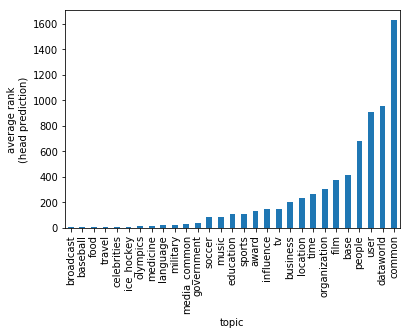

examples for "easy" topics:

example for topic broadcast: /broadcast/content/artist
example for topic baseball: /baseball/baseball_team/team_stats./baseball/baseball_team_stats/season
example for topic food: /food/food/nutrients./food/nutrition_fact/nutrient
example for topic travel: /travel/travel_destination/climate./travel/travel_destination_monthly_climate/month
example for topic celebrities: /celebrities/celebrity/celebrity_friends./celebrities/friendship/friend


examples for "difficult" topics:

example for topic base: /base/culturalevent/event/entity_involved
example for topic people: /people/person/gender
example for topic user: /user/tsegaran/random/taxonomy_subject/entry./user/tsegaran/random/taxonomy_entry/taxonomy
example for topic dataworld: /dataworld/gardening_hint/split_to
example for topic common: /common/topic/webpage./common/webpage/category


In [8]:
# analyse prediction_table_head.pkl
# find "easy" relations (relations that are part of triples with a good rank) and "difficult" relations
print('easy relations for head prediction (10 relations with the lowest average rank):\n')
for row in prediction_table_h[['p', 'rank']].groupby('p', as_index=False)['rank'].mean().\
                                             sort_values(by='rank').head(10).iterrows():
    print(id2relation[row[0]])

print('\n\n\ndifficult relations for head prediction (10 relations with the highest average rank):\n')
for row in prediction_table_h[['p', 'rank']].groupby('p', as_index=False)['rank'].mean().\
                                             sort_values(by='rank', ascending=False).head(10).iterrows():
    print(id2relation[row[0]])
    
print('\n\n\naverage rank of each topic (head prediction):')

df = prediction_table_h[['topic', 'rank']].groupby('topic', as_index=False)['rank'].mean().\
                                           sort_values(by='rank')
ax = df.plot.bar(x='topic', y='rank', rot=90, legend=False).set_ylabel('average rank\n(head prediction)')
plt.show()

# find examples for the "easy" topics
print('examples for "easy" topics:\n')
for index, topic in df.head(5)['topic'].iteritems():
    for index, row in prediction_table_h[['p', 'rank', 'topic']].sort_values(by='rank')[['p', 'topic']].iterrows():
        if row['topic'] == topic:
            print('example for topic {}: {}'.format(topic, id2relation[row['p']]))
            break

print('\n\nexamples for "difficult" topics:\n')
# find examples for the "difficult" topics
for index, topic in df.tail(5)['topic'].iteritems():
    for index, row in prediction_table_h[['p', 'rank', 'topic']].sort_values(by='rank', ascending=False)[['p', 'topic']].iterrows():
        if row['topic'] == topic:
            print('example for topic {}: {}'.format(topic, id2relation[row['p']]))
            break

proportion of relation types: {'n:m': 0.762, '1:n': 0.206, 'n:1': 0.024, '1:1': 0.008}


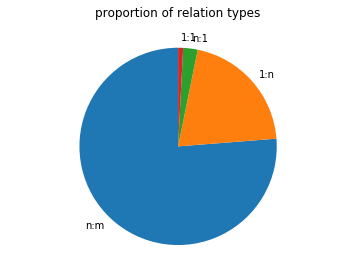

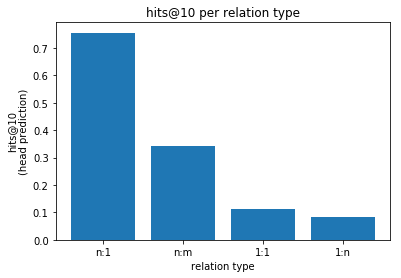

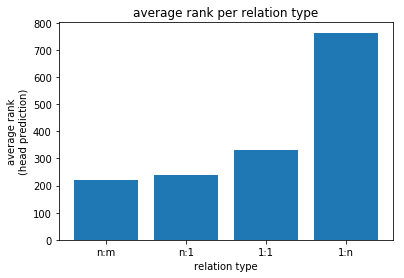

Hint: higher is better for hits@10, lower is better for the average rank



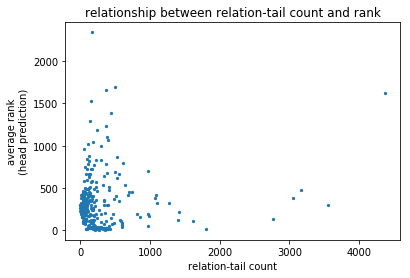

In [9]:
# analyse prediction_table_head.pkl
# plot relationship between relation-tail count and rank
rel_tail_count_to_avg_rank = dict()
relation_type_to_avg_rank = dict()  # keys: 1:1, 1:n, n:1, n:m
relation_type_to_hits10 = defaultdict(int)
relation_type_count = defaultdict(int)

for index, row in prediction_table_h.iterrows():
    relation_type = relation2type[row['p']]
    if row['rank'] <= 10:
        relation_type_to_hits10[relation_type] += 1
    relation_type_count[relation_type] += 1
        
    if relation_type not in relation_type_to_avg_rank:
        relation_type_to_avg_rank[relation_type] = (row['rank'], 1)
    else:
        relation_type_to_avg_rank[relation_type] = (relation_type_to_avg_rank[relation_type][0] +
                                                   row['rank'],
                                                   relation_type_to_avg_rank[relation_type][1] + 1)

    count_left = head_rel_count[(row['s'], row['p'])]
    count_right = rel_tail_count[(row['p'], row['o'])]
    if count_right not in rel_tail_count_to_avg_rank:
        rel_tail_count_to_avg_rank[count_right] = (row['rank'], 1)
    else:
        rel_tail_count_to_avg_rank[count_right] = (rel_tail_count_to_avg_rank[count_right][0] +
                                                   row['rank'],
                                                   rel_tail_count_to_avg_rank[count_right][1] + 1)

values_sum = sum(relation_type_count.values())
relation_type_to_proportion = {relation_type: round(count / values_sum, 3)
                               for relation_type, count in relation_type_count.items()}
print('proportion of relation types: ' + str(relation_type_to_proportion))

labels = sorted(relation_type_count, key=relation_type_count.get, reverse=True)
sizes = [relation_type_count[label] for label in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, shadow=False, startangle=90)
ax1.axis('equal')
plt.title('proportion of relation types\n')
plt.show()

for relation_type in relation_type_to_hits10:
    relation_type_to_hits10[relation_type] = relation_type_to_hits10[relation_type] \
                                             / relation_type_count[relation_type]

x = []
y = []
for relation_type in sorted(relation_type_to_hits10, key=relation_type_to_hits10.get, reverse=True):
    x.append(relation_type)
    y.append(relation_type_to_hits10[relation_type])
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x)
plt.title('hits@10 per relation type')
plt.xlabel('relation type')
plt.ylabel('hits@10\n(head prediction)')
plt.show()
print()

for relation_type, (sum_rank, num) in relation_type_to_avg_rank.items():
    relation_type_to_avg_rank[relation_type] = sum_rank / num

x = []
y = []
for relation_type in sorted(relation_type_to_avg_rank, key=relation_type_to_avg_rank.get):
    x.append(relation_type)
    y.append(relation_type_to_avg_rank[relation_type])
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x)
plt.title('average rank per relation type')
plt.xlabel('relation type')
plt.ylabel('average rank\n(head prediction)')
plt.show()

print('Hint: higher is better for hits@10, lower is better for the average rank\n')

for count, (sum_rank, num) in rel_tail_count_to_avg_rank.items():
    rel_tail_count_to_avg_rank[count] = sum_rank / num

x = []
y = []
for count in sorted(rel_tail_count_to_avg_rank):
    x.append(count)
    y.append(rel_tail_count_to_avg_rank[count])
    
plt.figure()
plt.title('relationship between relation-tail count and rank')
plt.xlabel('relation-tail count')
plt.ylabel('average rank\n(head prediction)')
plt.scatter(x, y, s=5)
plt.show()

In [10]:
# analyse prediction_table_head.pkl
# when is the models ranking bad? is there specific a pattern?
mask = prediction_table_h['rank'] > int(14541/2)  # 14541 = num diff. entities
prediction_table_bad = prediction_table_h[mask]
print('There are {} very bad head predictions:'.format(prediction_table_bad.shape[0]))
print('Hint: the numbers stand for a property of the corresponding triple (see more below)\n')

error_id_count = defaultdict(int)
triples_count = 0
rel_tail_counts_bad = set()
for index, row in tqdm(prediction_table_bad.iterrows()):
    rel_tail_counts_bad.add(rel_tail_count[(row[1], row[2])])
    head = id2entity[row[0]]
    relation = id2relation[row[1]]
    tail = id2entity[row[2]]

    head_id = torch.tensor([row[0]])
    relation_id = torch.tensor([row[1]])
    tail_id = torch.tensor([row[2]])
    scores_subject = model.predict_subject_scores(head_id, relation_id, tail_id)
    argsort_subject = torch.argsort(scores_subject, dim=1, descending=True)
    models_top10 = []
    for entity_id in argsort_subject[0][:10]:
        try:
            entity_name = mid2name[id2entity[entity_id.item()]]
            models_top10.append(entity_name)
        except:  # entity unknown
            pass
            
    # rank_subject = (argsort_subject == head_id).nonzero()
    # rank_subject = 1 + rank_subject[0][1].item()
    # assert rank_subject == row[3]

    try:
        mid2name[tail]
#         print('\ncorrect head: ' + mid2name[head])
#         print('given relation: ' + relation)
#         print('given tail: ' + mid2name[tail])
#         print('instead of the correct entity these entities got a high score:\n')
#         error_type_table = pd.DataFrame(columns=['entity name']+[i for i in range(8)])
        for entity_name in models_top10:
            try: 
                triple = (mid2name[head], relation, mid2name[tail])
                error_type = get_error_type(triple, predicted=entity_name, mode='head')
#                 row_dict = {'entity name': entity_name}
#                 row_dict.update({error_id: 'x' for error_id in error_type})
#                 error_type_table = error_type_table.append(row_dict, ignore_index=True)
                for error_id in error_type:
                    error_id_count[error_id] += 1
                triples_count += 1
            except Exception as e:
                print(e)
#         print(error_type_table.fillna('').to_string(index=False))
#         print()
    except:  # entity unknown
        pass

print('\n\ndescription for every error_id: ' + str(error_id2description_head))

error_id2percentage = {error_id: round(error_id_count[error_id] / triples_count, 3)
                       for error_id in error_id_count}
error_id2percentage = sorted(error_id2percentage.items())
print('\npercentage of very bad head predictions with the corresponding error_id: ' + str(error_id2percentage))

avg_rel_tail_count_bad = sum(rel_tail_counts_bad) / len(rel_tail_counts_bad)
print('\naverage relation-tail count for these very bad head predictions: ' + str(avg_rel_tail_count_bad))

0it [00:00, ?it/s]

There are 34 very bad head predictions:
Hint: the numbers stand for a property of the corresponding triple (see more below)



34it [14:14, 24.72s/it]



description for every error_id: {0: 'predicted head is actually correct', 1: 'predicted head is similar to true head, but not the same', 2: 'predicted head = given tail', 3: 'predicted head neither occured together with given relation nor with given tail', 4: 'predicted head and given relation never occured together', 5: 'predicted head and given tail never occured together', 6: 'wrong named entity type', 7: 'predicted head has correct named entity type and occured with the given relation'}

percentage of very bad head predictions with the corresponding error_id: [(3, 0.583), (4, 0.583), (5, 1.0), (6, 0.838), (7, 0.032)]

average relation-tail count for these very bad head predictions: 1203.0


In [11]:
# analyse prediction_table_head.pkl
# when is the models ranking good? is there specific a pattern?
mask = prediction_table_h['rank'] == 1
prediction_table_perfect_h = prediction_table_h[mask]
print('There are {} perfect head predictions:\n'.format(prediction_table_perfect_h.shape[0]))

rel_tail_counts_good = set()
for index, row in prediction_table_perfect_h.iterrows():
    rel_tail_counts_good.add(rel_tail_count[(row[1], row[2])])
    head = id2entity[row[0]]
    relation = id2relation[row[1]]
    tail = id2entity[row[2]]
    try:
        mid2name[tail]
        print(mid2name[head])
        print(relation)
        print(mid2name[tail])
        print()
    except:  # entity unknown
        pass

avg_rel_tail_count_good = sum(rel_tail_counts_good) / len(rel_tail_counts_good)
print('average relation-tail count for these good head predictions: ' + str(avg_rel_tail_count_good))

There are 2074 perfect head predictions:

Zürich
/travel/travel_destination/climate./travel/travel_destination_monthly_climate/month
October

England
/location/location/contains
Pontefract

2008 Summer Olympics
/olympics/olympic_games/participating_countries
Djibouti

2008 Summer Olympics
/olympics/olympic_games/participating_countries
Mauritania

Virginia
/location/statistical_region/religions./location/religion_percentage/religion
Presbyterianism

African Americans
/people/ethnicity/people
John Lee Hooker

egg
/food/food/nutrients./food/nutrition_fact/nutrient
pantothenic acid

Bachelor of Arts
/education/educational_degree/people_with_this_degree./education/education/institution
Royal Holloway, University of London

rock music
/music/genre/artists
Dio

Kings of Leon
/influence/influence_node/influenced_by
Queens of the Stone Age

Union of European Football Associations
/sports/sports_league/teams./sports/sports_league_participation/team
Finland national football team

Contact
/film/

Netherlands

Marriott International
/base/schemastaging/organization_extra/phone_number./base/schemastaging/phone_sandbox/service_language
English

piano
/music/performance_role/regular_performances./music/group_membership/group
Blood, Sweat & Tears

piano
/music/performance_role/regular_performances./music/group_membership/group
Oasis

piano
/music/performance_role/regular_performances./music/group_membership/group
Queen

Warner Bros. Records
/music/record_label/artist
The White Stripes

39th Canadian Parliament
/government/legislative_session/members./government/government_position_held/district_represented
Saskatchewan

hip hop music
/music/genre/artists
Will Smith

104th United States Congress
/government/legislative_session/members./government/government_position_held/district_represented
West Virginia

Golden Globe Award for Best Director
/award/award_category/nominees./award/award_nomination/nominated_for
As Good as It Gets

drum kit
/music/performance_role/regular_performances.

New York

keyboard instrument
/music/performance_role/regular_performances./music/group_membership/group
Nine Inch Nails

Bachelor of Science
/education/educational_degree/people_with_this_degree./education/education/institution
Emory University

Academy Award for Best Director
/award/award_category/winners./award/award_honor/ceremony
80th Academy Awards

marriage
/people/marriage_union_type/unions_of_this_type./people/marriage/location_of_ceremony
Buenos Aires

marriage
/people/marriage_union_type/unions_of_this_type./people/marriage/location_of_ceremony
Winchester

FC Bayern Munich
/sports/sports_team/sport
association football

King County
/location/hud_foreclosure_area/estimated_number_of_mortgages./measurement_unit/dated_integer/source
United States Department of Housing and Urban Development

Grammy Award for Best Male Pop Vocal Performance
/award/award_category/winners./award/award_honor/ceremony
2003 Grammy Awards

Total Recall
/film/film/release_date_s./film/film_regional_rele

/education/educational_degree/people_with_this_degree./education/education/institution
University of Guelph

110th United States Congress
/government/legislative_session/members./government/government_position_held/district_represented
New Hampshire

contiguous United States
/location/location/contains
Delaware

rock music
/music/genre/artists
Jewel

rock music
/music/genre/artists
Brian Jones

English people
/people/ethnicity/people
Bernard Hill

Mike Oldfield
/people/person/profession
musician

Coconino County
/location/hud_foreclosure_area/estimated_number_of_mortgages./measurement_unit/dated_integer/source
United States Department of Housing and Urban Development

Academy Award for Best Director
/award/award_category/nominees./award/award_nomination/nominated_for
Sayonara

Academy Award for Best Director
/award/award_category/category_of
Academy Awards

marriage
/people/marriage_union_type/unions_of_this_type./people/marriage/location_of_ceremony
Oahu

marriage
/people/marriage_uni


61st Primetime Emmy Awards
/award/award_ceremony/awards_presented./award/award_honor/award_winner
Marci Klein

51st Annual Grammy Awards
/award/award_ceremony/awards_presented./award/award_honor/award_winner
will.i.am

United States of America
/location/location/contains
Newton

United States of America
/location/location/contains
University of Virginia School of Law

United States of America
/location/location/contains
University of California, San Diego

United States of America
/location/location/contains
Wichita State University

United States of America
/location/country/second_level_divisions
Lycoming County

United States of America
/location/country/second_level_divisions
Berrien County

United States of America
/location/country/second_level_divisions
Lake County

guitar
/music/instrument/instrumentalists
John Denver

guitar
/music/performance_role/track_performances./music/track_contribution/role
Cymbal

guitar
/music/performance_role/regular_performances./music/group_member

In [12]:
# load prediction_table_tail.pkl
path = os.path.join(model_output_path, 'prediction_table_tail.pkl')
prediction_table_tail = pd.read_pickle(path)
prediction_table_tail['rank of true tail'] = pd.to_numeric(prediction_table_tail['rank of true tail'],
                                                           downcast='integer')

s = []
p = []
o = []
topics = []
for _, triple_str in prediction_table_tail['triple'].iteritems():
    triple = re.split(',', triple_str[1:-1])
    s.append(int(triple[0].strip()))
    p.append(int(triple[1].strip()))
    o.append(int(triple[2].strip()))
    topics.append(id2relation[int(triple[1].strip())].split('/')[1])

prediction_table_t = pd.DataFrame(columns=['s', 'p', 'o', 'rank'])
prediction_table_t['s'] = s
prediction_table_t['p'] = p
prediction_table_t['o'] = o
prediction_table_t['rank'] = prediction_table_tail['rank of true tail']
prediction_table_t['topic'] = topics

easy relations for tail prediction (10 relations with the lowest average rank):

/music/performance_role/track_performances./music/track_contribution/role
/education/educational_institution/students_graduates./education/education/student
/education/educational_institution_campus/educational_institution
/film/actor/film./film/performance/film
/baseball/baseball_team/team_stats./baseball/baseball_team_stats/season
/sports/sports_team/roster./american_football/football_historical_roster_position/position_s
/film/film/release_date_s./film/film_regional_release_date/film_release_region
/award/ranked_item/appears_in_ranked_lists./award/ranking/list
/location/administrative_division/country
/sports/sports_team/sport



difficult relations for tail prediction (10 relations with the highest average rank):

/base/biblioness/bibs_location/country
/sports/sports_team_location/teams
/tv/tv_personality/tv_regular_appearances./tv/tv_regular_personal_appearance/program
/business/business_operation/ind

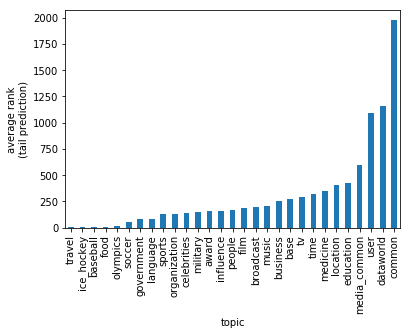

examples for "easy" topics:

example for topic travel: /travel/travel_destination/climate./travel/travel_destination_monthly_climate/month
example for topic ice_hockey: /ice_hockey/hockey_team/current_roster./sports/sports_team_roster/position
example for topic baseball: /baseball/baseball_team/team_stats./baseball/baseball_team_stats/season
example for topic food: /food/food/nutrients./food/nutrition_fact/nutrient
example for topic olympics: /olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country


examples for "difficult" topics:

example for topic education: /education/educational_institution/students_graduates./education/education/student
example for topic media_common: /media_common/netflix_genre/titles
example for topic user: /user/tsegaran/random/taxonomy_subject/entry./user/tsegaran/random/taxonomy_entry/taxonomy
example for topic dataworld: /dataworld/gardening_hint/split_to
example for topic common: /common/topic/webpage./common/webpage/category


In [13]:
# analyse prediction_table_tail.pkl
# find "easy" relations (relations that are part of triples with a good rank) and "difficult" relations

print('easy relations for tail prediction (10 relations with the lowest average rank):\n')
for row in prediction_table_t[['p', 'rank']].groupby('p', as_index=False)['rank'].mean().\
                                             sort_values(by='rank').head(10).iterrows():
    print(id2relation[row[0]])

print('\n\n\ndifficult relations for tail prediction (10 relations with the highest average rank):\n')
for row in prediction_table_t[['p', 'rank']].groupby('p', as_index=False)['rank'].mean().\
                                             sort_values(by='rank', ascending=False).head(10).iterrows():
    print(id2relation[row[0]])
    
print('\n\n\naverage rank of each topic (tail prediction:')
df = prediction_table_t[['topic', 'rank']].groupby('topic', as_index=False)['rank'].mean().\
                                           sort_values(by='rank')
ax = df.plot.bar(x='topic', y='rank', rot=90, legend=False).set_ylabel('average rank\n(tail prediction)')
plt.show()

# find examples for the "easy" topics
print('examples for "easy" topics:\n')
for index, topic in df.head(5)['topic'].iteritems():
    for index, row in prediction_table_t[['p', 'rank', 'topic']].sort_values(by='rank')[['p', 'topic']].iterrows():
        if row['topic'] == topic:
            print('example for topic {}: {}'.format(topic, id2relation[row['p']]))
            break

# find examples for the "difficult" topics
print('\n\nexamples for "difficult" topics:\n')
for index, topic in df.tail(5)['topic'].iteritems():
    for index, row in prediction_table_t[['p', 'rank', 'topic']].sort_values(by='rank', ascending=False)[['p', 'topic']].iterrows():
        if row['topic'] == topic:
            print('example for topic {}: {}'.format(topic, id2relation[row['p']]))
            break

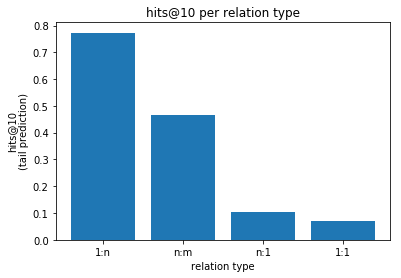

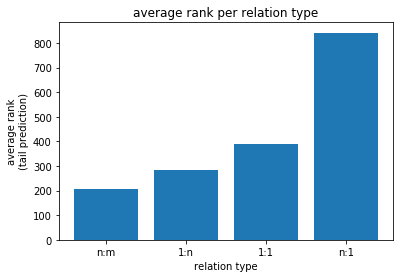

Hint: higher is better for hits@10, lower is better for the average rank



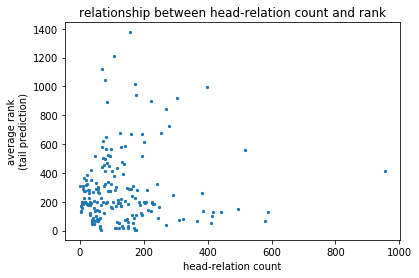

In [14]:
# analyse prediction_table_tail.pkl
# plot relationship between head-relation count and rank
head_rel_count_to_avg_rank = dict()
relation_type_to_avg_rank = dict()
relation_type_to_hits10 = defaultdict(int)
relation_type_count = defaultdict(int)

for index, row in prediction_table_t.iterrows():
    relation_type = relation2type[row['p']]
    if row['rank'] <= 10:
        relation_type_to_hits10[relation_type] += 1
    relation_type_count[relation_type] += 1

    if relation_type not in relation_type_to_avg_rank:
        relation_type_to_avg_rank[relation_type] = (row['rank'], 1)
    else:
        relation_type_to_avg_rank[relation_type] = (relation_type_to_avg_rank[relation_type][0] +
                                                    row['rank'],
                                                    relation_type_to_avg_rank[relation_type][1] + 1)

    count_left = head_rel_count[(row['s'], row['p'])]
    count_right = rel_tail_count[(row['p'], row['o'])]
    if count_left not in head_rel_count_to_avg_rank:
        head_rel_count_to_avg_rank[count_left] = (row['rank'], 1)
    else:
        head_rel_count_to_avg_rank[count_left] = (head_rel_count_to_avg_rank[count_left][0] +
                                                  row['rank'],
                                                  head_rel_count_to_avg_rank[count_left][1] + 1)

for relation_type in relation_type_to_hits10:
    relation_type_to_hits10[relation_type] = relation_type_to_hits10[relation_type] \
                                             / relation_type_count[relation_type]

x = []
y = []
for relation_type in sorted(relation_type_to_hits10, key=relation_type_to_hits10.get, reverse=True):
    x.append(relation_type)
    y.append(relation_type_to_hits10[relation_type])
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x)
plt.title('hits@10 per relation type')
plt.xlabel('relation type')
plt.ylabel('hits@10\n(tail prediction)')
plt.show()
print()

for relation_type, (sum_rank, num) in relation_type_to_avg_rank.items():
    relation_type_to_avg_rank[relation_type] = sum_rank / num

x = []
y = []
for relation_type in sorted(relation_type_to_avg_rank, key=relation_type_to_avg_rank.get):
    x.append(relation_type)
    y.append(relation_type_to_avg_rank[relation_type])
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x)
plt.title('average rank per relation type')
plt.xlabel('relation type')
plt.ylabel('average rank\n(tail prediction)')
plt.show()

print('Hint: higher is better for hits@10, lower is better for the average rank\n')

for count, (sum_avg_rank, num) in head_rel_count_to_avg_rank.items():
    head_rel_count_to_avg_rank[count] = sum_avg_rank / num

x = []
y = []
for count in sorted(head_rel_count_to_avg_rank):
    x.append(count)
    y.append(head_rel_count_to_avg_rank[count])
    
plt.figure()
plt.title('relationship between head-relation count and rank')
plt.xlabel('head-relation count')
plt.ylabel('average rank\n(tail prediction)')
plt.scatter(x, y, s=5)
plt.show()

In [15]:
# analyse prediction_table_tail.pkl
# when is the models ranking bad? is there specific a pattern?
mask = prediction_table_t['rank'] > int(14541/2)  # 14541 = num diff. entities
prediction_table_bad = prediction_table_t[mask]
print('There are {} very bad tail predictions:'.format(prediction_table_bad.shape[0]))
print('Hint: the numbers stand for a property of the corresponding triple (see more below)\n')

error_id_count = defaultdict(int)
triples_count = 0
head_rel_counts_bad = set()
for index, row in tqdm(prediction_table_bad.iterrows()):
    head_rel_counts_bad.add(head_rel_count[(row[0], row[1])])
    head = id2entity[row[0]]
    relation = id2relation[row[1]]
    tail = id2entity[row[2]]

    head_id = torch.tensor([row[0]]).to(device=PREFERRED_DEVICE)
    relation_id = torch.tensor([row[1]]).to(device=PREFERRED_DEVICE)
    tail_id = torch.tensor([row[2]]).to(device=PREFERRED_DEVICE)
    scores_object = model.predict_object_scores(head_id, relation_id, tail_id)
    argsort_object = torch.argsort(scores_object, dim=1, descending=True)
    models_top10 = []
    for entity_id in argsort_object[0][:10]:
        try:
            entity_name = mid2name[id2entity[entity_id.item()]]
            models_top10.append(entity_name)
        except:  # entity unknown
            pass
        
    # rank_object = (argsort_object == tail_id).nonzero()
    # rank_object = 1 + rank_object[0][1].item()
    # assert rank_object == row[3]

    try:
        mid2name[tail]
#         print('\ngiven head: ' + mid2name[head])
#         print('given relation: ' + relation)
#         print('correct tail: ' + mid2name[tail])
#         print('instead of the correct entity these entities got a high score: ')
        error_type_table = pd.DataFrame(columns=['entity name']+[i for i in range(8)])
        for entity_name in models_top10:
            try: 
                triple = (mid2name[head], relation, mid2name[tail])
                error_type = get_error_type(triple, predicted=entity_name, mode='tail')
#                 row_dict = {'entity name': entity_name}
#                 row_dict.update({error_id: 'x' for error_id in error_type})
#                 error_type_table = error_type_table.append(row_dict, ignore_index=True)
                for error_id in error_type:
                    error_id_count[error_id] += 1
                triples_count += 1
            except Exception as e:
                print(e)
#         print(error_type_table.fillna('').to_string(index=False))
#         print()
    except:  # entity unknown
        pass

print('\n\ndescription for every error_id: ' + str(error_id2description_tail))
error_id2percentage = {error_id: round(error_id_count[error_id] / triples_count, 3)
                       for error_id in error_id_count}
error_id2percentage = sorted(error_id2percentage.items())
print('\npercentage of very bad tail predictions with the corresponding error_id: ' + str(error_id2percentage))

avg_head_rel_count_bad = sum(head_rel_counts_bad) / len(head_rel_counts_bad)
print('\naverage head-relation count for these very bad tail predictions: ' + str(avg_head_rel_count_bad))

0it [00:00, ?it/s]

There are 78 very bad tail predictions:
Hint: the numbers stand for a property of the corresponding triple (see more below)



78it [13:41, 13.31s/it]



description for every error_id: {0: 'predicted tail is actually correct', 1: 'predicted tail is similar to true tail, but not the same', 2: 'predicted tail = given head', 3: 'predicted tail neither occured together with given relation nor with given head', 4: 'predicted tail and given relation never occured together', 5: 'predicted tail and given head never occured together', 6: 'wrong named entity type', 7: 'predicted tail has correct named entity type and occured with the given relation'}

percentage of very bad tail predictions with the corresponding error_id: [(1, 0.004), (3, 0.717), (4, 0.738), (5, 0.961), (6, 0.845), (7, 0.004)]

average head-relation count for these very bad tail predictions: 19.6


In [16]:
# analyse prediction_table_tail.pkl
# when is the models ranking good? is there specific a pattern?
mask = prediction_table_t['rank'] == 1
prediction_table_perfect_t = prediction_table_t[mask]
print('There are {} perfect tail predictions:\n'.format(prediction_table_perfect_t.shape[0]))

head_rel_counts_good = set()
for index, row in prediction_table_perfect_t.iterrows():
    head_rel_counts_good.add(head_rel_count[(row[0], row[1])])
    head = id2entity[row[0]]
    relation = id2relation[row[1]]
    tail = id2entity[row[2]]
    try:
        mid2name[tail]
        print(mid2name[head])
        print(relation)
        print(mid2name[tail])
        print()
    except:  # entity unknown
        pass

avg_head_rel_count_good = sum(head_rel_counts_good) / len(head_rel_counts_good)
print('average head-relation count for these good tail predictions: ' + str(avg_head_rel_count_good))

There are 5305 perfect tail predictions:

Zürich
/travel/travel_destination/climate./travel/travel_destination_monthly_climate/month
October

Winnie the Pooh
/film/film/release_date_s./film/film_regional_release_date/film_release_region
France

Bohemia
/olympics/olympic_participating_country/medals_won./olympics/olympic_medal_honor/medal
bronze medal

Asheville
/location/location/time_zones
Eastern Time Zone

Lycoming County
/location/statistical_region/rent50_2./measurement_unit/dated_money_value/currency
United States dollar

Virginia
/location/statistical_region/religions./location/religion_percentage/religion
Presbyterianism

War on Terror
/military/military_conflict/combatants./military/military_combatant_group/combatants
Canada

Grammy Award for Best Country Album
/award/award_category/winners./award/award_honor/ceremony
2001 Grammy Awards

Grammy Award for Best Country Album
/award/award_category/winners./award/award_honor/ceremony
2000 Grammy Awards

Christianity
/user/tsegaran

/film/film/other_crew./film/film_crew_gig/film_crew_role
visual effects

James Stewart
/people/person/gender
male organism

Click
/film/film/other_crew./film/film_crew_gig/film_crew_role
visual effects supervisor

Mexico
/olympics/olympic_participating_country/medals_won./olympics/olympic_medal_honor/medal
gold medal

Andrew Lau
/people/person/profession
film director

Charles County
/location/hud_foreclosure_area/estimated_number_of_mortgages./measurement_unit/dated_integer/source
United States Department of Housing and Urban Development

Charles County
/location/location/time_zones
Eastern Time Zone

Breaking and Entering
/film/film/film_format
Super 35

Harry Potter and the Order of the Phoenix
/film/film/other_crew./film/film_crew_gig/film_crew_role
sound editor

G.I. Joe: Retaliation
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Germany

Cornell University
/education/educational_institution/students_graduates./education/education/major_field_of_stu

Central European Time

John Riggi
/people/person/profession
television director

Danilo Donati
/people/person/gender
male organism

Snow Falling on Cedars
/film/film/genre
crime novel

Sean McNamara
/people/person/profession
film director

Lost in Translation
/film/film/other_crew./film/film_crew_gig/film_crew_role
make-up artist

Robert Carlock
/people/person/profession
television producer

Mick Jagger
/people/person/profession
musician

DePauw University
/education/educational_institution/students_graduates./education/education/major_field_of_study
economics

geography
/user/tsegaran/random/taxonomy_subject/entry./user/tsegaran/random/taxonomy_entry/taxonomy
Library of Congress Classification

Apple
/award/ranked_item/appears_in_ranked_lists./award/ranking/list
Fortune Global 500

Rare Ltd.
/business/business_operation/industry
video game industry

An Early Frost
/film/film/other_crew./film/film_crew_gig/film_crew_role
production sound mixer

Mike Judge
/base/schemastaging/person_ext

Library of Congress Classification

Brian Tyler
/people/person/gender
male organism

Extremely Loud and Incredibly Close
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Canada

The Life and Death of Peter Sellers
/film/film/release_date_s./film/film_regional_release_date/film_release_distribution_medium
DVD

Grammy Award for Best Contemporary Folk Album
/award/award_category/winners./award/award_honor/ceremony
2004 Grammy Awards

Mike Figgis
/people/person/profession
film director

Harvard College
/education/university/domestic_tuition./measurement_unit/dated_money_value/currency
United States dollar

Uganda
/olympics/olympic_participating_country/medals_won./olympics/olympic_medal_honor/medal
bronze medal

Palm Beach County
/location/location/time_zones
Eastern Time Zone

basketball
/olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country
Germany

Paul Schrader
/people/person/nationality
United States of America

The Da Vinci Code
/


Don Knotts
/people/person/nationality
United States of America

James Buchanan
/people/person/profession
politician

Martin Short
/people/person/languages
English

programming
/music/performance_role/regular_performances./music/group_membership/role
bass guitar

Persea americana
/food/food/nutrients./food/nutrition_fact/nutrient
carbohydrate

Robert F. McGowan
/people/person/nationality
United States of America

Taye Diggs
/award/award_nominee/award_nominations./award/award_nomination/award
Broadcast Film Critics Association Award for Best Cast

Anchorman: The Legend of Ron Burgundy
/film/film/language
English

Craig Thomas
/tv/tv_producer/programs_produced./tv/tv_producer_term/producer_type
executive producer

Coritiba F.C.
/sports/sports_team/colors
white

Jarhead
/film/film/film_format
Super 35

The Muppets
/film/film/release_date_s./film/film_regional_release_date/film_release_region
United Kingdom

Gillian Spencer
/people/person/profession
screenwriter

Gloria Stuart
/people/dece

technical support

Knight and Day
/film/film/release_date_s./film/film_regional_release_date/film_release_distribution_medium
DVD

Paul Dooley
/people/person/nationality
United States of America

Scary Movie 3
/film/film/genre
comedy

Kevin Michael Richardson
/people/person/profession
actor

John Hawkes
/people/person/profession
actor

Irwin Allen
/people/person/nationality
United States of America

Les Charles
/people/person/gender
male organism

cheese
/food/food/nutrients./food/nutrition_fact/nutrient
L-aspartic Acid

The Newton Boys
/film/film/other_crew./film/film_crew_gig/film_crew_role
special effects supervisor

Wynton Marsalis
/people/person/spouse_s./people/marriage/type_of_union
marriage

Sega
/base/schemastaging/organization_extra/phone_number./base/schemastaging/phone_sandbox/contact_category
customer service

Vincent van Gogh
/people/person/gender
male organism

Bill Paxton
/award/award_nominee/award_nominations./award/award_nomination/award
Primetime Emmy Award for Outst

DVD

Shrek the Third
/film/film/language
English

Phoenix
/base/petbreeds/city_with_dogs/top_breeds./base/petbreeds/dog_city_relationship/dog_breed
Golden Retriever

Miami Marlins
/sports/professional_sports_team/draft_picks./sports/sports_league_draft_pick/draft
2003 Major League Baseball draft

The Dark Knight
/film/film/release_date_s./film/film_regional_release_date/film_release_region
France

Mary Astor
/people/person/spouse_s./people/marriage/type_of_union
marriage

House of Sand and Fog
/film/film/cinematography
Roger Deakins

Gabriel Byrne
/film/actor/film./film/performance/special_performance_type
cameo appearance

G-Force
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Netherlands

Grammy Award for Song of the Year
/award/award_category/winners./award/award_honor/ceremony
2003 Grammy Awards

Oliver Platt
/people/person/spouse_s./people/marriage/type_of_union
marriage

Grammy Award for Best New Artist
/award/award_category/winners./award/award_ho

India

Rockland County
/location/location/time_zones
Eastern Time Zone

Danny Smith
/people/person/profession
television producer

Wonder Boys
/film/film/other_crew./film/film_crew_gig/film_crew_role
make-up artist

Thomas Haden Church
/award/award_nominee/award_nominations./award/award_nomination/award
Academy Award for Best Supporting Actor

Signs
/film/film/other_crew./film/film_crew_gig/film_crew_role
visual effects supervisor

curling
/olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country
France

Melissa Joan Hart
/people/person/religion
Catholicism

Gene Stupnitsky
/people/person/gender
male organism

Oklahoma!
/award/ranked_item/appears_in_ranked_lists./award/ranking/list
National Film Registry

Hamlet
/film/film/other_crew./film/film_crew_gig/film_crew_role
make-up artist

Frank Spotnitz
/award/award_nominee/award_nominations./award/award_nomination/award
Primetime Emmy Award for Outstanding Drama Series

Frank Spotnitz
/people/person/profession
screenwr

Beasts of the Southern Wild
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Austria

The Artist
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Italy

Sexy Beast
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Germany

Night at the Museum
/film/film/country
United Kingdom

Seychelles
/location/country/official_language
English

Thor
/film/film/featured_film_locations
Los Angeles

WALL·E
/film/film/genre
fantasy

Timothy Olyphant
/people/person/nationality
United States of America

David Carradine
/people/person/spouse_s./people/marriage/type_of_union
domestic partnership

Jean-Luc Godard
/people/person/spouse_s./people/marriage/type_of_union
marriage

1999 Grammy Awards
/award/award_ceremony/awards_presented./award/award_honor/award_winner
Johnny Cash

Transformers
/film/film/release_date_s./film/film_regional_release_date/film_release_region
United States of America

The World Is Not Enough
/f

English

24 (TV series)
/tv/tv_program/genre
drama film

University of Canterbury
/education/educational_institution/students_graduates./education/education/major_field_of_study
economics

Fritz Lang
/people/person/gender
male organism

Imogen Heap
/people/person/nationality
England

marriage
/people/marriage_union_type/unions_of_this_type./people/marriage/location_of_ceremony
Hawaii

Howard the Duck
/film/film/genre
thriller

Lauren Tom
/people/person/gender
female organism

Inception
/film/film/language
French

Cyprus
/organization/organization_member/member_of./organization/organization_membership/organization
World Bank

Jeremy Irons
/people/person/gender
male organism

Wuthering Heights
/film/film/release_date_s./film/film_regional_release_date/film_release_distribution_medium
DVD

Shining Through
/film/film/estimated_budget./measurement_unit/dated_money_value/currency
United States dollar

Nick Park
/tv/tv_producer/programs_produced./tv/tv_producer_term/producer_type
executive pr


Big Fish
/film/film/estimated_budget./measurement_unit/dated_money_value/currency
United States dollar

Isaiah Washington
/people/person/spouse_s./people/marriage/type_of_union
marriage

Penn Jillette
/people/person/spouse_s./people/marriage/type_of_union
marriage

Chris Columbus
/award/award_nominee/award_nominations./award/award_nomination/award
BAFTA Award for Best Film

Trevor Horn
/people/person/nationality
England

3000 Miles to Graceland
/film/film/film_format
Super 35

Around the World in 80 Days
/film/film/language
Spanish

Keith David
/people/person/profession
voice actor

Bangladesh
/organization/organization_member/member_of./organization/organization_membership/organization
United Nations

Gone Baby Gone
/film/film/distributors./film/film_film_distributor_relationship/region
United Kingdom

I Spy
/film/film/genre
thriller

Henry Corden
/people/person/gender
male organism

Urmila Matondkar
/people/person/profession
actor

The Treasure of the Sierra Madre
/film/film/release

singer-songwriter

Grammy Award for Best Traditional Pop Vocal Album
/award/award_category/winners./award/award_honor/ceremony
2003 Grammy Awards

The Pianist
/film/film/release_date_s./film/film_regional_release_date/film_release_region
United Kingdom

The Social Network
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Finland

Van Helsing
/film/film/other_crew./film/film_crew_gig/film_crew_role
visual effects supervisor

Jennifer Coolidge
/people/person/nationality
United States of America

Another World
/tv/tv_program/tv_producer./tv/tv_producer_term/producer_type
executive producer

Rocky V
/film/film/language
English

Herbert Hoover
/government/politician/government_positions_held./government/government_position_held/basic_title
president

1992 Winter Olympics
/olympics/olympic_games/medals_awarded./olympics/olympic_medal_honor/medal
silver medal

El Paso County
/location/hud_foreclosure_area/estimated_number_of_mortgages./measurement_unit/dated_integ

/people/person/languages
English

Grammy Award for Best Chamber Music Performance
/award/award_category/winners./award/award_honor/ceremony
2003 Grammy Awards

The Vow
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Japan

Roanoke
/location/statistical_region/rent50_2./measurement_unit/dated_money_value/currency
United States dollar

The Firm
/film/film/estimated_budget./measurement_unit/dated_money_value/currency
United States dollar

Lisa Kudrow
/people/person/profession
television producer

1972 Winter Olympics
/olympics/olympic_games/medals_awarded./olympics/olympic_medal_honor/medal
gold medal

Washoe County
/location/statistical_region/rent50_2./measurement_unit/dated_money_value/currency
United States dollar

Michael Clayton
/film/film/release_date_s./film/film_regional_release_date/film_release_distribution_medium
DVD

Canada
/base/aareas/schema/administrative_area/administrative_parent
Earth

Megan Fox
/people/person/religion
Catholicism

Shigeru

In [17]:
# analyse worst_predictions_head.pkl
path = os.path.join(model_output_path, 'worst_predictions_head.pkl')
worst_predictions_head = pd.read_pickle(path)
worst_predictions_head['rank'] = pd.to_numeric(worst_predictions_head['rank'], downcast='integer')
print(worst_predictions_head.head(10).to_string(index=False))

count_head_entities_worst = dict()
count_relations_worst = dict()
count_tail_entities_worst = dict()

for triple in worst_predictions_head['triple'].head(10):
    triple = re.split(' +', triple[1:-1].strip())
    entity_id1 = int(triple[0])
    relation_id = int(triple[1])
    entity_id2 = int(triple[2])
    count_head_entities_worst[entity_id1] = count_head_entities_train[entity_id1]
    count_relations_worst[relation_id] = count_relations_train[relation_id]
    count_tail_entities_worst[entity_id2] = count_tail_entities_train[entity_id2]

print('\nnumber of occurrences of this head entities in the training data (as head): '
      + str(count_head_entities_worst))

print('\nnumber of occurrences of this relations in the training data: '
      + str(count_relations_worst))

print('\nnumber of occurrences of this tail entities in the training data (as tail): '
      + str(count_tail_entities_worst))

              triple   rank
    [9530  129  271]  14482
 [10416   124 13886]  14174
 [12742   164  4600]  13149
 [12424     9 12573]  10983
 [ 2088   191 13836]   9684
    [9024  232 5831]   9473
    [ 302    9 7360]   9403
 [12597     3  7771]   8934
 [ 5404    85 13138]   8400
    [6730  100 6437]   8285

number of occurrences of this head entities in the training data (as head): {9530: 70, 10416: 1325, 12742: 37, 12424: 49, 2088: 13, 9024: 44, 302: 36, 12597: 330, 5404: 11, 6730: 62}

number of occurrences of this relations in the training data: {129: 5201, 124: 463, 164: 256, 9: 12157, 191: 10945, 232: 271, 3: 9465, 85: 7268, 100: 2337}

number of occurrences of this tail entities in the training data (as tail): {271: 10, 13886: 3, 4600: 131, 12573: 107, 13836: 380, 5831: 80, 7360: 21, 7771: 20, 13138: 48, 6437: 13}


In [18]:
# analyse worst_predictions_tail.pkl
path = os.path.join(model_output_path, 'worst_predictions_tail.pkl')
worst_predictions_tail = pd.read_pickle(path)
worst_predictions_tail['rank'] = pd.to_numeric(worst_predictions_tail['rank'], downcast='integer')

print(worst_predictions_tail.head(10).to_string(index=False))

count_head_entities_worst = dict()
count_relations_worst = dict()
count_tail_entities_worst = dict()

for triple in worst_predictions_tail['triple'].head(10):
    triple = re.split(' +', triple[1:-1].strip())
    entity_id1 = int(triple[0])
    relation_id = int(triple[1])
    entity_id2 = int(triple[2])
    count_head_entities_worst[entity_id1] = count_head_entities_train[entity_id1]
    count_relations_worst[relation_id] = count_relations_train[relation_id]
    count_tail_entities_worst[entity_id2] = count_tail_entities_train[entity_id2]

print('\nnumber of occurrences of this head entities in the training data (as head): '
      + str(count_head_entities_worst))

print('\nnumber of occurrences of this relations in the training data: '
      + str(count_relations_worst))

print('\nnumber of occurrences of this tail entities in the training data (as tail): '
      + str(count_tail_entities_worst))

              triple   rank
    [3757    4 7089]  14541
    [6203    3 4788]  14541
 [  535    68 12613]  14541
 [10677   183  6221]  14541
 [ 8903    50 10191]  14541
    [4727  190 9530]  14541
 [11549   167 13244]  14541
 [11325   194 11473]  14541
    [ 695   68 1168]  14541
 [11364     3  5468]  14541

number of occurrences of this head entities in the training data (as head): {3757: 49, 6203: 115, 535: 54, 10677: 40, 8903: 5, 4727: 35, 11549: 22, 11325: 20, 695: 31, 11364: 135}

number of occurrences of this relations in the training data: {4: 5673, 3: 9465, 68: 9494, 183: 2063, 50: 3612, 190: 3738, 167: 381, 194: 251}

number of occurrences of this tail entities in the training data (as tail): {7089: 12, 4788: 14, 12613: 8, 6221: 14, 10191: 3612, 9530: 78, 13244: 177, 11473: 58, 1168: 20, 5468: 23}


In [19]:
# analyse best_predictions_head.pkl
path = os.path.join(model_output_path, 'best_predictions_head.pkl')
best_predictions_head = pd.read_pickle(path)
best_predictions_head['rank'] = pd.to_numeric(best_predictions_head['rank'], downcast='integer')

print(best_predictions_head.head(10).to_string(index=False))

count_head_entities_best = dict()
count_relations_best = dict()
count_tail_entities_best = dict()

for triple in best_predictions_head['triple'].head(10):
    triple = re.split(' +', triple[1:-1].strip())
    entity_id1 = int(triple[0])
    relation_id = int(triple[1])
    entity_id2 = int(triple[2])
    count_head_entities_best[entity_id1] = count_head_entities_train[entity_id1]
    count_relations_best[relation_id] = count_relations_train[relation_id]
    count_tail_entities_best[entity_id2] = count_tail_entities_train[entity_id2]

print('\nnumber of occurrences of this head entities in the training data (as head): '
      + str(count_head_entities_best))

print('\nnumber of occurrences of this relations in the training data: '
      + str(count_relations_best))

print('\nnumber of occurrences of this tail entities in the training data (as tail): '
      + str(count_tail_entities_best))

print('\n\nHint: There are {} head predictions with rank 1'.format(prediction_table_perfect_h.shape[0]))

              triple  rank
    [2005  236 7594]     1
 [11495    80  8918]     1
 [13327    14  8213]     1
 [13610    37  4366]     1
    [ 815   57 9824]     1
    [9444   89 5359]     1
    [3152  176 9818]     1
 [10213    68 12735]     1
 [  147    50 10191]     1
    [5363  149 2722]     1

number of occurrences of this head entities in the training data (as head): {2005: 0, 11495: 48, 13327: 16, 13610: 13, 815: 25, 9444: 30, 3152: 45, 10213: 17, 147: 39, 5363: 86}

number of occurrences of this relations in the training data: {236: 411, 80: 977, 14: 2992, 37: 208, 57: 728, 89: 5305, 176: 797, 68: 9494, 50: 3612, 149: 5880}

number of occurrences of this tail entities in the training data (as tail): {7594: 411, 8918: 47, 8213: 9, 4366: 2590, 9824: 56, 5359: 175, 9818: 168, 12735: 17, 10191: 3612, 2722: 39}


Hint: There are 2074 head predictions with rank 1


In [20]:
# analyse best_predictions_tail.pkl
path = os.path.join(model_output_path, 'best_predictions_tail.pkl')
best_predictions_tail = pd.read_pickle(path)
best_predictions_tail['rank'] = pd.to_numeric(best_predictions_tail['rank'], downcast='integer')

print(best_predictions_tail.head(10).to_string(index=False))

count_head_entities_best = dict()
count_relations_best = dict()
count_tail_entities_best = dict()

count_entities_best = dict()
count_relations_best = dict()
for triple in best_predictions_tail['triple'].head(10):
    triple = re.split(' +', triple[1:-1].strip())
    entity_id1 = int(triple[0])
    relation_id = int(triple[1])
    entity_id2 = int(triple[2])
    count_head_entities_best[entity_id1] = count_head_entities_train[entity_id1]
    count_relations_best[relation_id] = count_relations_train[relation_id]
    count_tail_entities_best[entity_id2] = count_tail_entities_train[entity_id2]

print('\nnumber of occurrences of this head entities in the training data (as head): '
      + str(count_head_entities_best))

print('\nnumber of occurrences of this relations in the training data: '
      + str(count_relations_best))

print('\nnumber of occurrences of this tail entities in the training data (as tail): '
      + str(count_tail_entities_best))

print('\n\nHint: There are {} tail predictions with rank 1'.format(prediction_table_perfect_t.shape[0]))

              triple  rank
 [ 4471   129 13510]     1
 [13707   138 10559]     1
    [1276    5 2486]     1
    [9052  189 1133]     1
    [5770   57 6963]     1
 [  702   100 11847]     1
    [ 702   10 1566]     1
 [10670    96   477]     1
 [ 1098    82 10628]     1
 [13644   191  1372]     1

number of occurrences of this head entities in the training data (as head): {4471: 273, 13707: 4, 1276: 24, 9052: 11, 5770: 17, 702: 230, 10670: 50, 1098: 35, 13644: 23}

number of occurrences of this relations in the training data: {129: 5201, 138: 373, 5: 2834, 189: 2465, 57: 728, 100: 2337, 10: 15989, 96: 12893, 82: 264, 191: 10945}

number of occurrences of this tail entities in the training data (as tail): {13510: 1, 10559: 4285, 2486: 68, 1133: 194, 6963: 10, 11847: 36, 1566: 86, 477: 349, 10628: 19, 1372: 864}


Hint: There are 5305 tail predictions with rank 1


In [21]:
# analyse compare_head_tail.pkl
print('is the model better in predicting heads or tails?')
path = os.path.join(model_output_path, 'compare_head_tail.pkl')
compare_head_tail_df = pd.read_pickle(path)
display(compare_head_tail_df.round(3).style.hide_index())

is the model better in predicting heads or tails?


metric,heads and tails,only heads,only tails
MR,286.357,334.012,238.702
MRR,0.257,0.167,0.347
HITS@1,0.18,0.101,0.259
HITS@3,0.281,0.18,0.382
HITS@10,0.407,0.297,0.518



statistical values:


,entity_id,average position
count,14541.0,14541.0
mean,7270.0,7270.0
std,4197.8,946.1
min,0.0,5088.5
25%,3635.0,6537.6
50%,7270.0,7232.2
75%,10905.0,7895.3
max,14540.0,9769.7




entities with lowest average position (top 10):


entity_name,average position,count head in train,count head in test
Irish,5088,1,0
Persian,5105,7,1
American English,5146,0,1
Czech,5147,2,2
Yiddish,5147,6,0
Hebrew,5150,3,0
Scots,5150,2,0
67th World Science Fiction Convention,5182,8,0
Welsh,5183,2,0
7043,5198,2,0


Hint: "count head in train" = number of occurrences of the entities in the training data (as head)
"count head in test" = number of occurrences of the entities in the test data (as head)


entities with highest average position (last 10):


entity_name,average position,count head in train,count head in test
Saving Private Ryan,9693,48,2
The French Connection,9694,45,4
The Dark Knight,9708,88,18
Jurassic Park,9727,60,5
The Talented Mr. Ripley,9747,34,2
Titanic,9753,55,1
Gladiator,9754,47,3
Iron Man,9759,85,6
Star Wars Episode IV: A New Hope,9767,96,7
Transformers: Dark of the Moon,9770,77,6


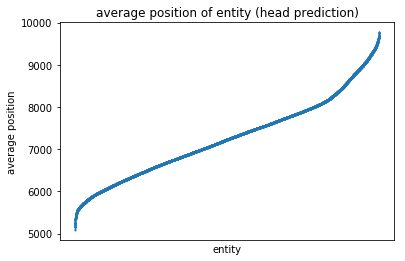

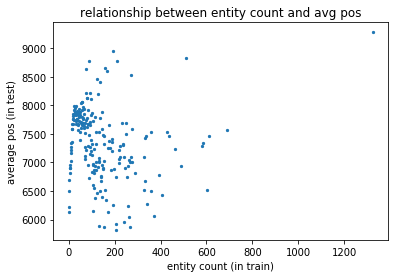

In [22]:
# analyse avg_position_table_head.pkl
path = os.path.join(model_output_path, 'avg_position_table_head.pkl')
avg_position_table_head = pd.read_pickle(path)

count_entities_highest = dict()  # train data
count_entities_highest_t = dict()  # test data
for entity_id in avg_position_table_head['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_head_entities_train[entity_id]
    count_entities_highest_t[entity_name] = count_head_entities_test[entity_id]

count_entities_lowest = dict()
count_entities_lowest_t = dict()
for entity_id in avg_position_table_head['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_head_entities_train[entity_id]
    count_entities_lowest_t[entity_name] = count_head_entities_test[entity_id]

print('\nstatistical values:')
display(avg_position_table_head.describe().round(1))
print('\n\nentities with lowest average position (top 10):')
entity_names = []
average_positions = []
for index, row in avg_position_table_head.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    average_positions.append(row['average position'])
average_positions = [round(avg_pos) for avg_pos in average_positions]
avg_position_table_head_tmp = pd.DataFrame(columns=['entity_name', 'average position'])
avg_position_table_head_tmp['entity_name'] = entity_names
avg_position_table_head_tmp['average position'] = average_positions

avg_position_table_head_tmp['count head in train'] = avg_position_table_head_tmp['entity_name'].\
                                                     map(count_entities_highest)
avg_position_table_head_tmp['count head in test'] = avg_position_table_head_tmp['entity_name'].\
                                                    map(count_entities_highest_t)
display(avg_position_table_head_tmp.style.hide_index())
print('Hint: \"count head in train\" = number of occurrences of the entities in the training data (as head)')
print('\"count head in test\" = number of occurrences of the entities in the test data (as head)')

print('\n\nentities with highest average position (last 10):')
entity_names = []
average_positions = []
for index, row in avg_position_table_head.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    average_positions.append(row['average position'])
average_positions = [round(avg_pos) for avg_pos in average_positions]
avg_position_table_head_tmp = pd.DataFrame(columns=['entity_name', 'average position'])
avg_position_table_head_tmp['entity_name'] = entity_names
avg_position_table_head_tmp['average position'] = average_positions

avg_position_table_head_tmp['count head in train'] = avg_position_table_head_tmp['entity_name'].\
                                                     map(count_entities_lowest)
avg_position_table_head_tmp['count head in test'] = avg_position_table_head_tmp['entity_name'].\
                                                    map(count_entities_lowest_t)
display(avg_position_table_head_tmp.style.hide_index())
print()

y = avg_position_table_head['average position']
x = np.arange(len(y))
plt.figure()
plt.title('average position of entity (head prediction)')
plt.xlabel('entity')
plt.ylabel('average position')
plt.xticks([])
plt.scatter(x, y, s=1)
plt.show()

entity_count_to_avg_pos = dict()
for index, row in avg_position_table_head.iterrows():
    entity_count = count_head_entities_train[row['entity_id']]
    if entity_count not in entity_count_to_avg_pos:
        entity_count_to_avg_pos[entity_count] = (row['average position'], 1)
    else:
        entity_count_to_avg_pos[entity_count] = (entity_count_to_avg_pos[entity_count][0]
                                                 + row['average position'],
                                                 entity_count_to_avg_pos[entity_count][1] + 1)

for entity_count, (sum_avg_pos, num) in entity_count_to_avg_pos.items():
    entity_count_to_avg_pos[entity_count] = sum_avg_pos / num

x = []
y = []
for entity_count in sorted(entity_count_to_avg_pos):
    x.append(entity_count)
    y.append(entity_count_to_avg_pos[entity_count])    
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id

plt.figure()
plt.title('relationship between entity count and avg pos')
plt.xlabel('entity count (in train)')
plt.ylabel('average pos (in test)')
plt.scatter(x, y, s=5)
plt.show()


statistical values:



,entity_id,average position
count,14541.0,14541.0
mean,7270.0,7270.0
std,4197.8,1319.4
min,0.0,4880.0
25%,3635.0,6036.1
50%,7270.0,7042.0
75%,10905.0,8529.6
max,14540.0,10152.2




entities with lowest average position (top 10):


entity_name,average position,count tail in train,count tail in test
singer-songwriter,4880,286,27
pediatrics,4892,2,0
Hamilton County,4955,2,0
dentistry,4962,3,1
Welsh,4964,8,1
Korean,4975,14,3
ghost,4978,0,0
children's literature,4979,6,1
Swedish,4980,25,1
Portuguese,5004,38,2


Hint: "count tail in train" = number of occurrences of the entities in the training data (as tail)
"count tail in test" = number of occurrences of the entities in the test data (as tail)


entities with highest average position (last 10):


entity_name,average position,count tail in train,count tail in test
2012,9976,14,3
Angels & Demons,9982,8,1
The Avengers,10007,28,2
The Golden Compass,10008,20,4
Harry Potter and the Half-Blood Prince,10009,26,5
X-Men Origins: Wolverine,10031,15,2
The Last Emperor,10055,37,2
Memento,10060,20,3
Black Swan,10065,33,5
Transformers,10152,30,0


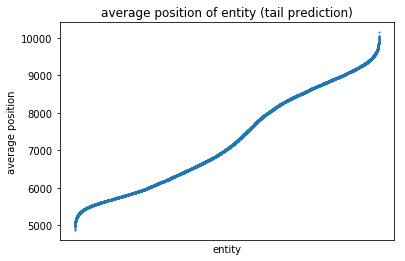

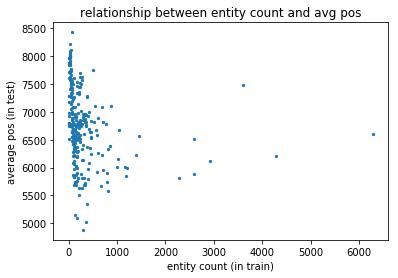

In [23]:
# analyse avg_position_table_tail.pkl
path = os.path.join(model_output_path, 'avg_position_table_tail.pkl')
avg_position_table_tail = pd.read_pickle(path)

count_entities_highest = dict()  # train data
count_entities_highest_t = dict()  # test data
for entity_id in avg_position_table_tail['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_tail_entities_train[entity_id]
    count_entities_highest_t[entity_name] = count_tail_entities_test[entity_id]

count_entities_lowest = dict()
count_entities_lowest_t = dict()
for entity_id in avg_position_table_tail['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_tail_entities_train[entity_id]
    count_entities_lowest_t[entity_name] = count_tail_entities_test[entity_id]

print('\nstatistical values:\n')
display(avg_position_table_tail.describe().round(1))

print('\n\nentities with lowest average position (top 10):')
entity_names = []
average_positions = []
for index, row in avg_position_table_tail.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    average_positions.append(row['average position'])
average_positions = [round(avg_pos) for avg_pos in average_positions]
avg_position_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'average position'])
avg_position_table_tail_tmp['entity_name'] = entity_names
avg_position_table_tail_tmp['average position'] = average_positions

avg_position_table_tail_tmp['count tail in train'] = avg_position_table_tail_tmp['entity_name'].\
                                                     map(count_entities_highest)
avg_position_table_tail_tmp['count tail in test'] = avg_position_table_tail_tmp['entity_name'].\
                                                    map(count_entities_highest_t)
display(avg_position_table_tail_tmp.style.hide_index())
print('Hint: \"count tail in train\" = number of occurrences of the entities in the training data (as tail)')
print('\"count tail in test\" = number of occurrences of the entities in the test data (as tail)')

print('\n\nentities with highest average position (last 10):')
entity_names = []
average_positions = []
for index, row in avg_position_table_tail.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    average_positions.append(row['average position'])
average_positions = [round(avg_pos) for avg_pos in average_positions]
avg_position_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'average position'])
avg_position_table_tail_tmp['entity_name'] = entity_names
avg_position_table_tail_tmp['average position'] = average_positions

avg_position_table_tail_tmp['count tail in train'] = avg_position_table_tail_tmp['entity_name'].\
                                                     map(count_entities_lowest)
avg_position_table_tail_tmp['count tail in test'] = avg_position_table_tail_tmp['entity_name'].\
                                                    map(count_entities_lowest_t)
display(avg_position_table_tail_tmp.style.hide_index())
print()

y = avg_position_table_tail['average position']
x = np.arange(len(y))
plt.figure()
plt.title('average position of entity (tail prediction)')
plt.xlabel('entity')
plt.ylabel('average position')
plt.xticks([])
plt.scatter(x, y, s=1)
plt.show()

entity_count_to_avg_pos = dict()
for index, row in avg_position_table_tail.iterrows():
    entity_count = count_tail_entities_train[row['entity_id']]
    if entity_count not in entity_count_to_avg_pos:
        entity_count_to_avg_pos[entity_count] = (row['average position'], 1)
    else:
        entity_count_to_avg_pos[entity_count] = (entity_count_to_avg_pos[entity_count][0] +
                                                 row['average position'],
                                                 entity_count_to_avg_pos[entity_count][1] + 1)

for entity_count, (sum_avg_pos, num) in entity_count_to_avg_pos.items():
    entity_count_to_avg_pos[entity_count] = sum_avg_pos / num

x = []
y = []
for entity_count in sorted(entity_count_to_avg_pos):
    x.append(entity_count)
    y.append(entity_count_to_avg_pos[entity_count])

plt.figure()
plt.title('relationship between entity count and avg pos')
plt.xlabel('entity count (in train)')
plt.ylabel('average pos (in test)')
plt.scatter(x, y, s=5)
plt.show()

In [ ]:
# analyse highly_ranked_table_head.pkl
path = os.path.join(model_output_path, 'highly_ranked_table_head.pkl')
highly_ranked_table_head = pd.read_pickle(path)

entity_in_top10_count_head = defaultdict(int)
for index, row in highly_ranked_table_head.iterrows():
    entity_in_top10_count_head[row['entity_id']] = row['count']

count_entities_highest = dict()
for entity_id in highly_ranked_table_head['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_head_entities_train[entity_id]

count_entities_lowest = dict()
for entity_id in highly_ranked_table_head['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_head_entities_train[entity_id]

print('\nstatistical values:\n')
display(highly_ranked_table_head.describe().round(1))

print('\n\nentities with highest count (top 10)')
print('(shows how often the respective entity gets a position between 1 and 10)\n')
entity_names = []
counts = []
for index, row in highly_ranked_table_head.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
highly_ranked_table_head_tmp = pd.DataFrame(columns=['entity_name', 'count'])
highly_ranked_table_head_tmp['entity_name'] = entity_names
highly_ranked_table_head_tmp['count'] = counts

highly_ranked_table_head_tmp['count head in train'] = highly_ranked_table_head_tmp['entity_name'].\
                                                      map(count_entities_highest)
display(highly_ranked_table_head_tmp.style.hide_index())

print('\n\nentities with lowest count (last 10)')
print('(shows how often the respective entity gets a position between 1 and 10)\n')
entity_names = []
counts = []
for index, row in highly_ranked_table_head.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
highly_ranked_table_head_tmp = pd.DataFrame(columns=['entity_name', 'count'])
highly_ranked_table_head_tmp['entity_name'] = entity_names
highly_ranked_table_head_tmp['count'] = counts

highly_ranked_table_head_tmp['count head in train'] = highly_ranked_table_head_tmp['entity_name'].\
                                                      map(count_entities_lowest)
display(highly_ranked_table_head_tmp.style.hide_index())

mask = highly_ranked_table_head['count'] > 100
num = highly_ranked_table_head[mask].shape[0]
print('\nnumber of entities with count > 100: ' + str(num))

mask = highly_ranked_table_head['count'] == 0
num = highly_ranked_table_head[mask].shape[0]
print('number of entities with count 0: ' + str(num))

mask = highly_ranked_table_head['count'] == 1
num = highly_ranked_table_head[mask].shape[0]
print('number of entities with count 1: ' + str(num))

mask = highly_ranked_table_head['count'] < 10
num = highly_ranked_table_head[mask].shape[0]
print('number of entities with count < 10: ' + str(num))


statistical values:



,entity_id,count
count,5626.0,5626.0
mean,6720.0,36.4
std,4254.4,91.5
min,0.0,1.0
25%,2868.8,2.0
50%,6607.5,5.0
75%,10473.8,26.0
max,14525.0,1310.0




entities with highest count (top 10)
(shows how often the respective entity gets a position between 1 and 10)



entity_name,count,count head in train
The Social Network,1310,92
Brad Pitt,1147,136
Iron Man,933,85
Johnny Depp,912,98
Transformers: Dark of the Moon,842,77
Moulin Rouge!,807,44
Transformers,793,77
Robert De Niro,782,94
The Lord of the Rings: The Fellowship of the Ring,772,90
Steve Martin,762,70




entities with lowest count (last 10)
(shows how often the respective entity gets a position between 1 and 10)



entity_name,count,count head in train
1976 Winter Olympics,1,20
Stephen Graham,1,39
Braveheart,1,44
Ryan Tedder,1,31
Taliban insurgency,1,6
Bosnian War,1,5
atheism,1,0
Tamil,1,6
Gujarati,1,2
Gore Vidal,1,17



number of entities with count > 100: 522
number of entities with count 0: 0
number of entities with count 1: 1405
number of entities with count < 10: 3422


In [ ]:
# analyse highly_ranked_table_tail.pkl
path = os.path.join(model_output_path, 'highly_ranked_table_tail.pkl')
highly_ranked_table_tail = pd.read_pickle(path)

entity_in_top10_count_tail = defaultdict(int)
for index, row in highly_ranked_table_tail.iterrows():
    entity_in_top10_count_tail[row['entity_id']] = row['count']

count_entities_highest = dict()
for entity_id in highly_ranked_table_tail['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_tail_entities_train[entity_id]
    
count_entities_lowest = dict()
for entity_id in highly_ranked_table_tail['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_tail_entities_train[entity_id]

print('\nstatistical values:\n')
display(highly_ranked_table_tail.describe().round(1))

print('\n\nentities with highest count (top 10)')
print('(shows how often the respective entity gets a position between 1 and 10)')
entity_names = []
counts = []
for index, row in highly_ranked_table_tail.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
highly_ranked_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'count'])
highly_ranked_table_tail_tmp['entity_name'] = entity_names
highly_ranked_table_tail_tmp['count'] = counts

highly_ranked_table_tail_tmp['count tail in train'] = highly_ranked_table_tail_tmp['entity_name'].\
                                                      map(count_entities_highest)
display(highly_ranked_table_tail_tmp.style.hide_index())

print('\n\nentities with lowest count (last 10)')
print('(shows how often the respective entity gets a position between 1 and 10)')
entity_names = []
counts = []
for index, row in highly_ranked_table_tail.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
highly_ranked_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'count'])
highly_ranked_table_tail_tmp['entity_name'] = entity_names
highly_ranked_table_tail_tmp['count'] = counts

highly_ranked_table_tail_tmp['count tail in train'] = highly_ranked_table_tail_tmp['entity_name'].\
                                                      map(count_entities_lowest)
display(highly_ranked_table_tail_tmp.style.hide_index())

mask = highly_ranked_table_tail['count'] > 100
num = highly_ranked_table_tail[mask].shape[0]
print('\nnumber of entities with count > 100: ' + str(num))

mask = highly_ranked_table_tail['count'] == 0
num = highly_ranked_table_tail[mask].shape[0]
print('number of entities with count 0: ' + str(num))

mask = highly_ranked_table_tail['count'] == 1
num = highly_ranked_table_tail[mask].shape[0]
print('number of entities with count 1: ' + str(num))

mask = highly_ranked_table_tail['count'] < 10
num = highly_ranked_table_tail[mask].shape[0]
# print('number of entities with count < 10: ' + str(num))


statistical values:



,entity_id,count
count,5291.0,5291.0
mean,6706.1,38.7
std,4168.3,112.0
min,0.0,1.0
25%,3027.5,2.0
50%,6569.0,5.0
75%,10254.0,23.0
max,14533.0,1646.0




entities with highest count (top 10)
(shows how often the respective entity gets a position between 1 and 10)


entity_name,count,count tail in train
Canada,1646,683
United Kingdom,1584,1443
Germany,1573,705
United States of America,1485,6289
England,1364,465
Italy,1303,558
France,1201,772
Australia,1159,538
India,1117,450
New York City,1100,1010




entities with lowest count (last 10)
(shows how often the respective entity gets a position between 1 and 10)


entity_name,count,count tail in train
2001: A Space Odyssey,1,15
Evanston,1,19
Anton Chekhov,1,15
Golden Lion,1,18
Road to Perdition,1,29
Clash of the Titans,1,11
Jaws,1,20
1622,1,11
Williamsport,1,4
Terry Jones,1,7



number of entities with count > 100: 472
number of entities with count 0: 0
number of entities with count 1: 1296


In [ ]:
# analyse top_ranked_table_head.pkl
path = os.path.join(model_output_path, 'top_ranked_table_head.pkl')
top_ranked_table_head = pd.read_pickle(path)

entity_first_place_count_head = defaultdict(int)
for index, row in top_ranked_table_head.iterrows():
    entity_first_place_count_head[row['entity_id']] = row['count']

count_entities_highest = dict()
for entity_id in top_ranked_table_head['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_head_entities_train[entity_id]

count_entities_lowest = dict()
for entity_id in top_ranked_table_head['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_head_entities_train[entity_id]

print('\nstatistical values:\n')
display(top_ranked_table_head.describe().round(1))

print('\n\nentities with highest count (top 10)')
print('(shows how often the respective entity is on the first place in models ranking)\n')
entity_names = []
counts = []
for index, row in top_ranked_table_head.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
top_ranked_table_head_tmp = pd.DataFrame(columns=['entity_name', 'count'])
top_ranked_table_head_tmp['entity_name'] = entity_names
top_ranked_table_head_tmp['count'] = counts

top_ranked_table_head_tmp['count head in train'] = top_ranked_table_head_tmp['entity_name'].\
                                                   map(count_entities_highest)
display(top_ranked_table_head_tmp.style.hide_index())

print('\n\nentities with lowest count (last 10)')
print('(shows how often the respective entity is on the first place in models ranking)\n')
entity_names = []
counts = []
for index, row in top_ranked_table_head.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
top_ranked_table_head_tmp = pd.DataFrame(columns=['entity_name', 'count'])
top_ranked_table_head_tmp['entity_name'] = entity_names
top_ranked_table_head_tmp['count'] = counts

top_ranked_table_head_tmp['count head in train'] = top_ranked_table_head_tmp['entity_name'].\
                                                   map(count_entities_lowest)
display(top_ranked_table_head_tmp.style.hide_index())

mask = top_ranked_table_head['count'] > 100
num = top_ranked_table_head[mask].shape[0]
print('\nnumber of entities with count > 100: ' + str(num))

mask = top_ranked_table_head['count'] == 0
num = top_ranked_table_head[mask].shape[0]
print('number of entities with count 0: ' + str(num))

mask = top_ranked_table_head['count'] == 1
num = top_ranked_table_head[mask].shape[0]
print('number of entities with count 1: ' + str(num))

mask = top_ranked_table_head['count'] < 10
num = top_ranked_table_head[mask].shape[0]
print('number of entities with count < 10: ' + str(num))


statistical values:



,entity_id,count
count,1367.0,1367.0
mean,7647.8,15.0
std,4130.2,40.1
min,28.0,1.0
25%,4317.5,1.0
50%,8112.0,2.0
75%,11206.5,8.5
max,14517.0,467.0




entities with highest count (top 10)
(shows how often the respective entity is on the first place in models ranking)



entity_name,count,count head in train
The Social Network,467,92
10191,400,0
Yoko Ono,333,22
rock music,320,359
Columbia University,310,115
Bill Clinton,302,19
James Franco,300,46
Academy Award for Best Picture,269,357
Madonna,254,99
United Kingdom,246,510




entities with lowest count (last 10)
(shows how often the respective entity is on the first place in models ranking)



entity_name,count,count head in train
Indigenous peoples of the Americas,1,7
CBS,1,50
Sacramento County,1,8
Switzerland,1,85
Vanessa Williams,1,29
1976 Winter Olympics,1,20
Michael Shannon,1,66
Library of Congress Classification,1,0
Tony Award for Best Original Score,1,23
Terry Gilliam,1,29



number of entities with count > 100: 52
number of entities with count 0: 0
number of entities with count 1: 547
number of entities with count < 10: 1045


In [ ]:
# analyse top_ranked_table_tail.pkl
path = os.path.join(model_output_path, 'top_ranked_table_tail.pkl')
top_ranked_table_tail = pd.read_pickle(path)

entity_first_place_count_tail = defaultdict(int)
for index, row in top_ranked_table_tail.iterrows():
    entity_first_place_count_tail[row['entity_id']] = row['count']

count_entities_highest = dict()
for entity_id in top_ranked_table_tail['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_tail_entities_train[entity_id]

count_entities_lowest = dict()
for entity_id in top_ranked_table_tail['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_tail_entities_train[entity_id]

print('\nstatistical values:\n')
display(top_ranked_table_tail.describe().round(1))

print('\n\nentities with highest count (top 10)')
print('(shows how often the respective entity is on the first place in models ranking)')
entity_names = []
counts = []
for index, row in top_ranked_table_tail.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
top_ranked_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'count'])
top_ranked_table_tail_tmp['entity_name'] = entity_names
top_ranked_table_tail_tmp['count'] = counts

top_ranked_table_tail_tmp['count tail in train'] = top_ranked_table_tail_tmp['entity_name'].\
                                                   map(count_entities_highest)
display(top_ranked_table_tail_tmp.style.hide_index())

print('\n\nentities with lowest count (last 10)')
print('(shows how often the respective entity is on the first place in models ranking)')
entity_names = []
counts = []
for index, row in top_ranked_table_tail.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
top_ranked_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'count'])
top_ranked_table_tail_tmp['entity_name'] = entity_names
top_ranked_table_tail_tmp['count'] = counts

top_ranked_table_tail_tmp['count tail in train'] = top_ranked_table_tail_tmp['entity_name'].\
                                                   map(count_entities_lowest)
display(top_ranked_table_tail_tmp.style.hide_index())

mask = top_ranked_table_tail['count'] > 100
num = top_ranked_table_tail[mask].shape[0]
print('\nnumber of entities with count > 100: ' + str(num))

mask = top_ranked_table_tail['count'] == 0
num = top_ranked_table_tail[mask].shape[0]
print('number of entities with count 0: ' + str(num))

mask = top_ranked_table_tail['count'] == 1
num = top_ranked_table_tail[mask].shape[0]
print('number of entities with count 1: ' + str(num))

mask = top_ranked_table_tail['count'] < 10
num = top_ranked_table_tail[mask].shape[0]
print('number of entities with count < 10: ' + str(num))


statistical values:



,entity_id,count
count,1310.0,1310.0
mean,7343.7,15.6
std,3933.9,44.0
min,44.0,1.0
25%,4327.0,1.0
50%,7539.5,3.0
75%,10714.8,9.0
max,14525.0,582.0




entities with highest count (top 10)
(shows how often the respective entity is on the first place in models ranking)


entity_name,count,count tail in train
United States of America,582,6289
United Kingdom,574,1443
David Bowie,475,36
Los Angeles,433,684
English,355,2590
United States dollar,308,4285
Canada,295,683
male organism,276,2928
marriage,268,2586
10191,258,3612




entities with lowest count (last 10)
(shows how often the respective entity is on the first place in models ranking)


entity_name,count,count tail in train
Atlantic County,1,8
Little Nicky,1,28
constitutional monarchy,1,52
Brad Grey,1,23
Octopussy,1,16
University of North Carolina at Chapel Hill,1,33
Brendon Small,1,13
Alameda County,1,12
Tim Burton,1,26
Kevin Kline,1,25



number of entities with count > 100: 46
number of entities with count 0: 0
number of entities with count 1: 482
number of entities with count < 10: 996


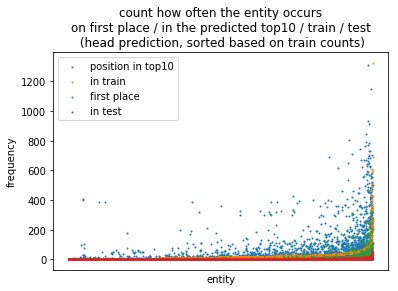

most intersting section:


In [ ]:
# head prediction: plot how often the entity occurs in the predicted top10 / on first place / train / 
# test (sorted based on train counts)
y_train = []
y_test = []
y_predicted_top10 = []
y_predicted_top1 = []

all_entities = list(id2entity.keys())
all_head_entities_train = list(count_head_entities_train.keys())
entities_not_head_in_train = np.setdiff1d(all_entities, all_head_entities_train)
assert len(all_entities) == len(entities_not_head_in_train) + len(all_head_entities_train)

for entity_id in entities_not_head_in_train:
    y_train.append(count_head_entities_train[entity_id])
    y_test.append(count_head_entities_test[entity_id])
    y_predicted_top10.append(entity_in_top10_count_head[entity_id])
    y_predicted_top1.append(entity_first_place_count_head[entity_id])

for entity_id in sorted(count_head_entities_train, key=count_head_entities_train.get):
    y_train.append(count_head_entities_train[entity_id])
    y_test.append(count_head_entities_test[entity_id])
    y_predicted_top10.append(entity_in_top10_count_head[entity_id])
    y_predicted_top1.append(entity_first_place_count_head[entity_id])
    
assert len(y_train) == len(y_test)
assert len(y_test) == len(y_predicted_top10)
assert len(y_test) == len(y_predicted_top1)
x = [i for i in range(len(y_train))]

plt.figure()
plt.title('count how often the entity occurs\non first place / in the predicted top10 / train / ' \
          + 'test\n (head prediction, sorted based on train counts)')
plt.xlabel('entity')
plt.ylabel('frequency')
plt.xticks([])

plt.scatter(x, y_predicted_top10, label='position in top10', s=1)
plt.scatter(x, y_train, label='in train', s=1)
plt.scatter(x, y_predicted_top1, label='first place', s=1)
plt.scatter(x, y_test, label='in test', s=1)
plt.legend()
plt.show()

print('most intersting section:')

plt.figure()
plt.title('count how often the entity occurs\non first place / in the predicted top10 / train / ' \
          + 'test\n (head prediction, sorted based on train counts)')
plt.xlabel('entity')
plt.ylabel('frequency')
plt.xticks([])

plt.scatter(x, y_predicted_top10, label='position in top10', s=1)
plt.scatter(x, y_train, label='in train', s=1)
plt.scatter(x, y_predicted_top1, label='first place', s=1)
plt.scatter(x, y_test, label='in test', s=1)
plt.legend()
plt.axis([10000, 15000, 0, 300])  # xmin, xmax, ymin, ymax
plt.show()

entity_ids = []
differences = []  # difference between count predicted and count true
true_head_counts = []
pred_head_counts = []
head_in_train_counts = []
entity_in_train_counts = []

for entity_id in id2entity.keys():
    entity_ids.append(entity_id)
    true_head_counts.append(count_head_entities_test[entity_id])
    pred_head_counts.append(entity_first_place_count_head[entity_id])
    difference = entity_first_place_count_head[entity_id] - count_head_entities_test[entity_id]
    differences.append(difference)
    head_in_train_counts.append(count_head_entities_train[entity_id])
    entity_in_train_counts.append(count_head_entities_train[entity_id]
                                  + count_tail_entities_train[entity_id])

entity_names = []
for entity_id in entity_ids:
    try:
        entity_name = mid2name[id2entity[entity_id]]
        if len(entity_name) > 39:
            entity_name = entity_name[:39] + '...'
        entity_names.append(entity_name)
    except:
        entity_names.append(entity_id)

difference_df = pd.DataFrame(columns=['entity', 'true head count', 'pred head count', 'difference', 
                                      'head in train count', 'entity in train count'])
difference_df['entity'] = entity_names
difference_df['true head count'] = true_head_counts
difference_df['pred head count'] = pred_head_counts
difference_df['difference'] = differences
difference_df['head in train count'] = head_in_train_counts
difference_df['entity in train count'] = entity_in_train_counts
difference_df = difference_df.sort_values(by='difference', ascending=False)

print('\nentities that were predicted far too often:')
display(difference_df.head(10).style.hide_index())
print('\n\nentities that were predicted far too seldom:')
display(difference_df.tail(10).sort_values(by='difference').style.hide_index())

In [ ]:
# tail prediction: plot how often the entity occurs in the predicted top10 / on first place / train /
# test (sorted based on train counts)
y_train = []
y_test = []
y_predicted_top10 = []
y_predicted_top1 = []

all_tail_entities_train = list(count_tail_entities_train.keys())
entities_not_tail_in_train = np.setdiff1d(all_entities, all_tail_entities_train)
assert len(all_entities) == len(entities_not_tail_in_train) + len(all_tail_entities_train)

for entity_id in entities_not_tail_in_train:
    y_train.append(count_tail_entities_train[entity_id])
    y_test.append(count_tail_entities_test[entity_id])
    y_predicted_top10.append(entity_in_top10_count_tail[entity_id])
    y_predicted_top1.append(entity_first_place_count_tail[entity_id])

for entity_id in sorted(count_tail_entities_train, key=count_tail_entities_train.get):
    y_train.append(count_tail_entities_train[entity_id])
    y_test.append(count_tail_entities_test[entity_id])
    y_predicted_top10.append(entity_in_top10_count_tail[entity_id])
    y_predicted_top1.append(entity_first_place_count_tail[entity_id])
    
assert len(y_train) == len(y_test)
assert len(y_test) == len(y_predicted_top10)
assert len(y_test) == len(y_predicted_top1)
x = [i for i in range(len(y_train))]

plt.figure()
plt.title('count how often the entity occurs\non first place / in the predicted top10 / train / ' \
          + 'test\n (tail prediction, sorted based on train counts)')
plt.xlabel('entity')
plt.ylabel('frequency')
plt.xticks([])

plt.scatter(x, y_predicted_top10, label='position in top10', s=1)
plt.scatter(x, y_train, label='in train', s=1)
plt.scatter(x, y_predicted_top1, label='first place', s=1)
plt.scatter(x, y_test, label='in test', s=1)
plt.legend()
plt.show()

print('most intersting section:')

plt.figure()
plt.title('count how often the entity occurs\non first place / in the predicted top10 / train / ' \
          + 'test\n (tail prediction, sorted based on train counts)')
plt.xlabel('entity')
plt.ylabel('frequency')
plt.xticks([])

plt.scatter(x, y_predicted_top10, label='position in top10', s=1)
plt.scatter(x, y_train, label='in train', s=1)
plt.scatter(x, y_predicted_top1, label='first place', s=1)
plt.scatter(x, y_test, label='in test', s=1)
plt.legend()
plt.axis([10000, 15000, 0, 300])  # xmin, xmax, ymin, ymax
plt.show()

entity_ids = []
differences = []  # difference between count predicted and count true
true_tail_counts = []
pred_tail_counts = []
tail_in_train_counts = []
entity_in_train_counts = []

for entity_id in id2entity.keys():
    entity_ids.append(entity_id)
    true_tail_counts.append(count_tail_entities_test[entity_id])
    pred_tail_counts.append(entity_first_place_count_tail[entity_id])
    difference = entity_first_place_count_tail[entity_id] - count_tail_entities_test[entity_id]
    differences.append(difference)
    tail_in_train_counts.append(count_tail_entities_train[entity_id])
    entity_in_train_counts.append(count_head_entities_train[entity_id]
                                  + count_tail_entities_train[entity_id])

entity_names = []
for entity_id in entity_ids:
    try:
        entity_name = mid2name[id2entity[entity_id]]
        if len(entity_name) > 39:
            entity_name = entity_name[:39] + '...'
        entity_names.append(entity_name)
    except:
        entity_names.append(entity_id)

difference_df = pd.DataFrame(columns=['entity', 'true tail count', 'pred tail count', 'difference', 
                                      'tail in train count', 'entity in train count'])
difference_df['entity'] = entity_names
difference_df['true tail count'] = true_tail_counts
difference_df['pred tail count'] = pred_tail_counts
difference_df['difference'] = differences
difference_df['tail in train count'] = tail_in_train_counts
difference_df['entity in train count'] = entity_in_train_counts
difference_df = difference_df.sort_values(by='difference', ascending=False)

print('\nentities that were predicted far too often:')
display(difference_df.head(10).style.hide_index())
print('\n\nentities that were predicted far too seldom:')
display(difference_df.tail(10).sort_values(by='difference').style.hide_index())